In [123]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import FuncFormatter
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.ticker as mticker
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer

In [124]:
postings_df = pd.read_csv('job_postings_updated.csv')

In [125]:
postings_df.columns

Index(['position', 'date', 'WorkType', 'levelMapping', 'Title', 'Company',
       'Location', 'Link', 'job description', 'extracted_skills',
       'salary_range', 'compensation_period', 'min_range', 'max_range',
       'ref_salary'],
      dtype='object')

In [126]:
postings_df[~postings_df.isna().any(axis = 1)].shape[0]

1857

In [127]:
postings_df['extracted_skills'].iloc[0]

'Jenkins, Octopus, Docker, Kubernetes, Git, Azure, HTML, CSS, Angular, Databases'

In [128]:
grouped_df = pd.crosstab(postings_df['position'], postings_df['levelMapping'], margins=True).reset_index()
grouped_df.columns.name = None

In [129]:
grouped_df

,position,associate,entry_level,mid_senior,All
0,blockchain developer,44,40,184,268
1,business intelligence analyst,206,237,288,731
2,cloud solutions architect,110,176,339,625
3,cyber security specialist,154,176,209,539
4,data scientist,158,194,141,493
5,database administrator,152,119,323,594
6,devops engineer,160,183,218,561
7,it support specialist,106,176,149,431
8,machine learning engineer,74,117,78,269
9,network administrator,176,212,222,610


In [130]:
postings_df_with_salary = postings_df[~postings_df.isna().any(axis = 1)]

In [131]:
grouped_df = pd.crosstab(postings_df_with_salary['position'], postings_df_with_salary['levelMapping'], margins=True).reset_index()
grouped_df.columns.name = None

In [132]:
grouped_df

,position,associate,entry_level,mid_senior,All
0,blockchain developer,21,15,92,128
1,business intelligence analyst,38,68,76,182
2,cloud solutions architect,32,35,72,139
3,cyber security specialist,32,34,48,114
4,data scientist,48,66,42,156
5,database administrator,47,38,67,152
6,devops engineer,59,50,66,175
7,it support specialist,31,49,49,129
8,machine learning engineer,30,45,24,99
9,network administrator,53,49,44,146


In [133]:
postings_df['levelMapping'].unique()

array(['entry_level', 'associate', 'mid_senior'], dtype=object)

In [134]:
# Assuming levelMapping has three possible values: 'Beginner', 'Intermediate', 'Advanced'
beginner_df = postings_df[postings_df['levelMapping'] == 'associate']
intermediate_df = postings_df[postings_df['levelMapping'] == 'entry_level']
advanced_df = postings_df[postings_df['levelMapping'] == 'mid_senior']

In [135]:
postings_df['skills'] = postings_df['extracted_skills'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
postings_df['skills_list'] = postings_df['skills'].str.split(', ')
skill_df = postings_df.explode('skills_list')
skill_counts = skill_df['skills_list'].str.title().value_counts()
print(skill_counts)

skills_list
Python             1735
Sql                1565
Aws                1188
Javascript          860
Azure               798
                   ... 
Abbyy                 1
Hyland (Onbase)       1
Lfs                   1
Crms                  1
Renovations           1
Name: count, Length: 14910, dtype: int64


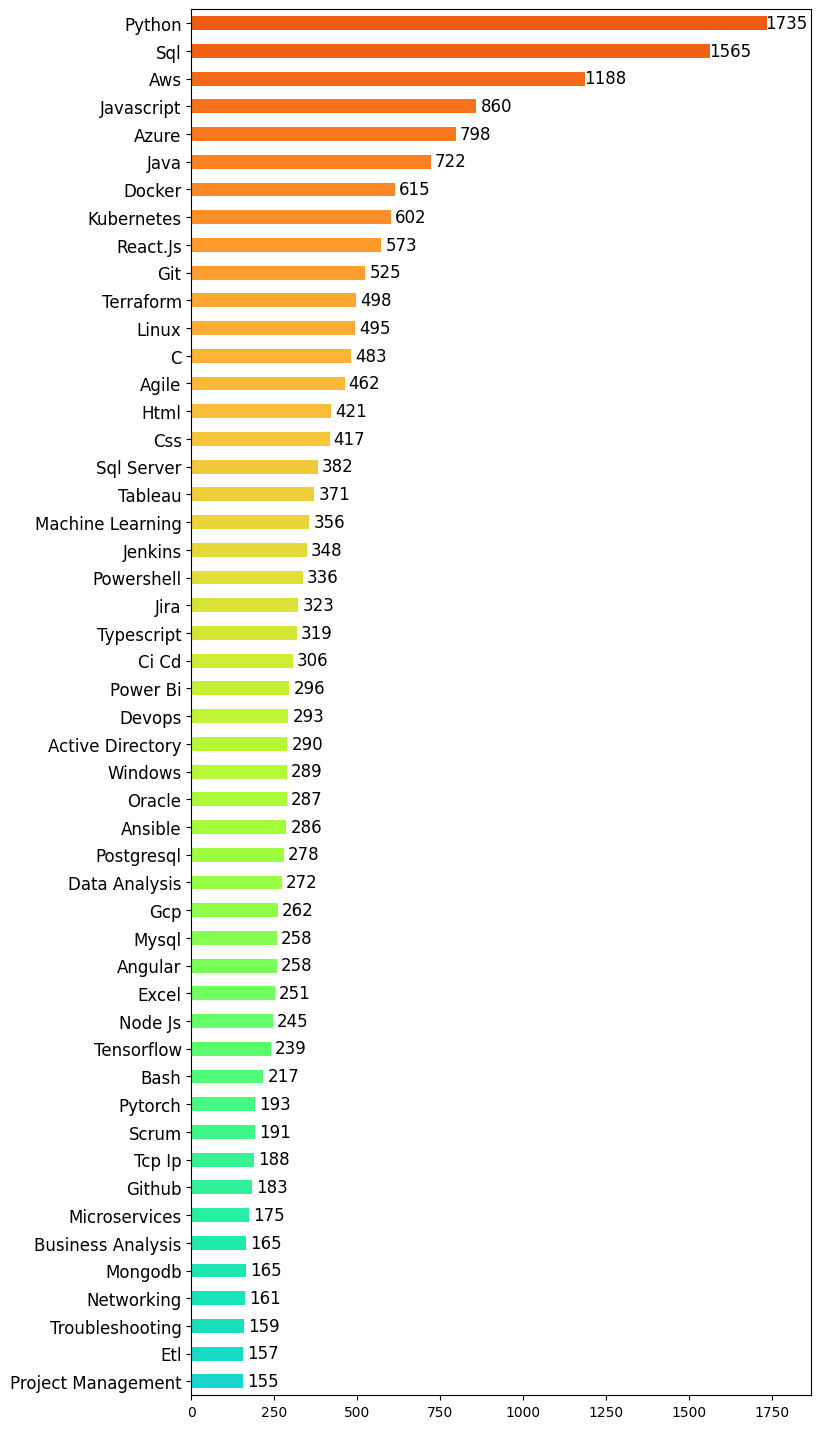

In [136]:
color_map = plt.colormaps.get_cmap('turbo')
colors = color_map(np.linspace(0.3, 0.8, 50))

plt.figure(figsize=(8, 18))
bars = skill_counts[:50].sort_values(ascending=True).plot(kind='barh', color=colors)

for bar in bars.patches:
    plt.text(
        bar.get_width() + 60,  
        bar.get_y() + bar.get_height() / 2,  
        f'{int(bar.get_width())}', 
        ha='center', va='center', fontsize=12, color='black'
    )
bars.set_ylabel('')
plt.yticks(fontsize=12)

plt.xlim(0, skill_counts.max() + 135) 
plt.savefig('figures/top50skills.jpeg', bbox_inches='tight')

plt.show()

In [137]:
postings_df[postings_df['ref_salary'] > 100000].shape[0]

1144

In [138]:
postings_df['ref_salary'].describe()

count      1857.000000
mean     123709.510767
std       54884.068235
min          62.500000
25%       84900.000000
50%      114400.000000
75%      152500.000000
max      815750.000000
Name: ref_salary, dtype: float64

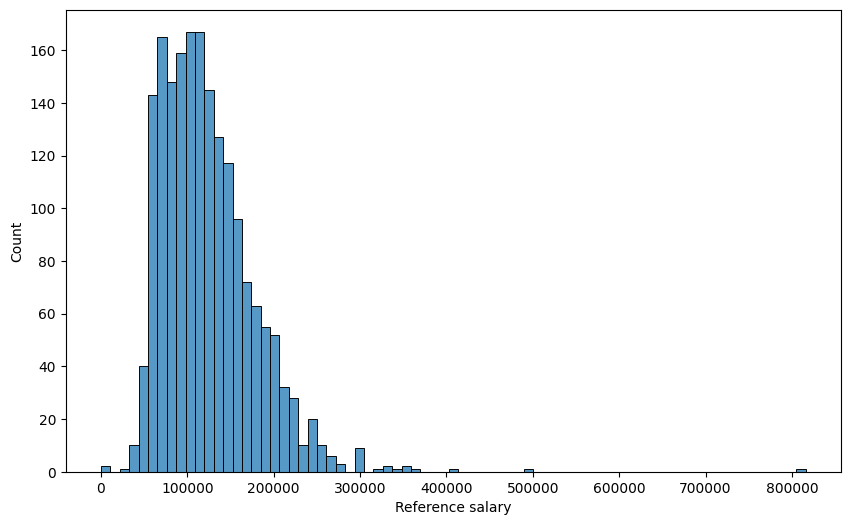

In [139]:

plt.figure(figsize=(10, 6))
sns.histplot(x=postings_df['ref_salary'])
plt.xlabel('Reference salary')
plt.savefig('figures/salary.jpeg', bbox_inches='tight')
#plt.title('Boxplot of Ref Salary')
plt.show()

C:\Users\luanc\AppData\Local\Temp\ipykernel_12072\3406563075.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='center', fontsize=13)


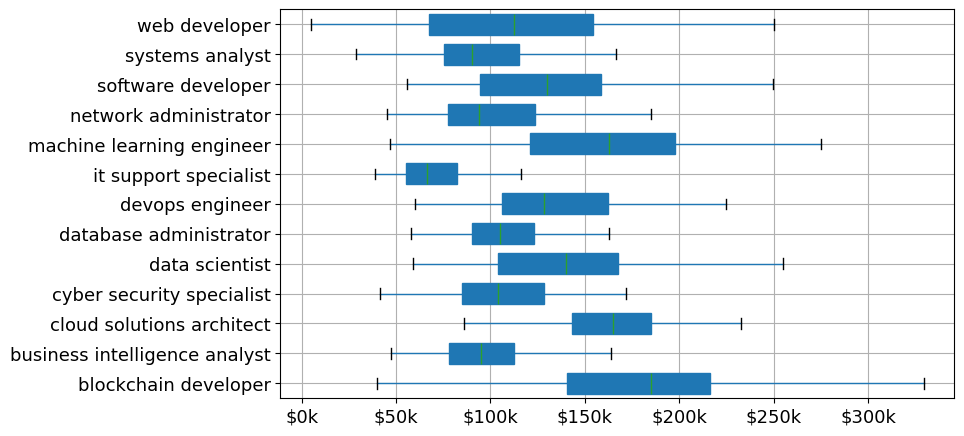

In [140]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(10, 5))  # Adjusted height to make the figure more horizontal
postings_df.boxplot(column='ref_salary', by='position', vert=False, patch_artist=True, showfliers=False, widths=0.7, ax=ax)

ax.set_title('')
ax.set_ylabel('')
fig.suptitle('')

# Rotate x-ticks 90 degrees
ax.set_xticklabels(ax.get_xticklabels(), ha='center', fontsize=13)
ax.tick_params(axis='y', labelsize=13)

# Format the x-ticks using a lambda function
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))

# Adjust layout
fig.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)

# Save the figure
fig.savefig('figures/boxplots_positions.jpeg', bbox_inches='tight')

plt.show()

C:\Users\luanc\AppData\Local\Temp\ipykernel_12072\115623575.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), ha='center', fontsize=13)


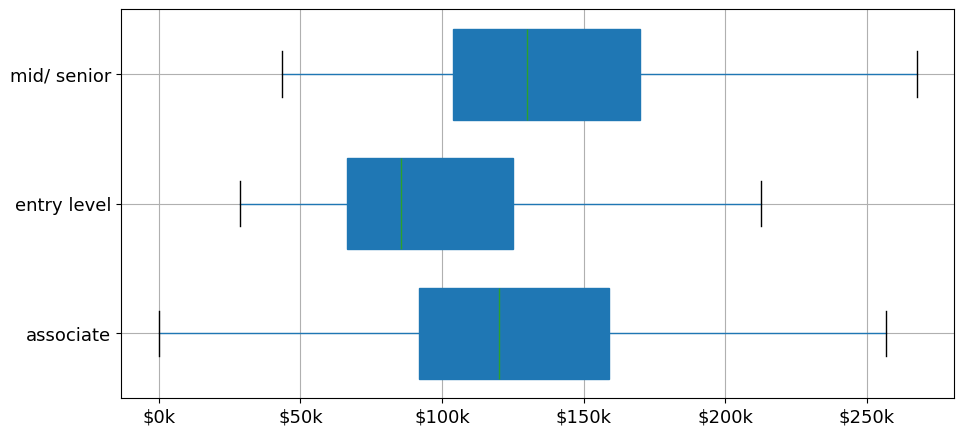

In [141]:
# Create the boxplot
fig, ax = plt.subplots(figsize=(10, 5))  # Adjusted height to make the figure more horizontal
postings_df.boxplot(column='ref_salary', by='levelMapping', vert=False, patch_artist=True, showfliers=False, widths=0.7, ax=ax)

ax.set_title('')
ax.set_ylabel('')
fig.suptitle('')

# Rotate x-ticks 90 degrees
ax.set_xticklabels(ax.get_xticklabels(), ha='center', fontsize=13)
ax.tick_params(axis='y', labelsize=13)

yticks = [tick.get_text() for tick in ax.get_yticklabels()]
ytick_labels = ['mid/ senior' if tick == 'mid_senior' else 'entry level' if tick == 'entry_level' else tick for tick in yticks]
ax.set_yticklabels(ytick_labels)

# Format the x-ticks using a lambda function
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))

# Adjust layout
fig.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)

# Save the figure
fig.savefig('figures/boxplots_levels.jpeg', bbox_inches='tight')

plt.show()

In [142]:
# Create a binary matrix for the skills
skills = list(set(skill for sublist in postings_df['skills_list'] for skill in sublist))
skills_matrix = pd.DataFrame(0, index=postings_df.index, columns=skills)

for i, skills_list in enumerate(postings_df['skills_list']):
    for skill in skills_list:
        skills_matrix.at[i, skill] = 1

# Concatenate the skills matrix with the original dataframe
postings_df = pd.concat([postings_df, skills_matrix], axis=1)

# Calculate the mean salary for each skill
skill_salary = postings_df[skills].multiply(postings_df['ref_salary'], axis=0)
skill_salary_mean = skill_salary.sum() / postings_df[skills].sum()
# Calculate the count of each skill
skill_count = postings_df[skills].sum()

In [143]:
# Combine the mean salary and count into a single DataFrame
skill_stats = pd.DataFrame({'mean_salary': skill_salary_mean, 'count': skill_count})

In [144]:
# Filter out skills with mean salary greater than zero
filtered_skill_stats = skill_stats[skill_stats['mean_salary'] > 0]

# Order by biggest mean salary
filtered_skill_stats = filtered_skill_stats.sort_values(by='mean_salary', ascending=False)

# Display the filtered and ordered DataFrame
filtered_skill_stats.to_csv('skills_check.csv')

In [145]:
skill_salary_df = postings_df.explode('skills_list')

# Get the top 50 skills by count
top_50_skills = skill_salary_df['skills_list'].value_counts().nlargest(50).sort_values(ascending=True).index

# Filter the DataFrame to include only the top 50 skills
filtered_df = skill_salary_df[skill_salary_df['skills_list'].isin(top_50_skills)]

In [146]:
filtered_df

,position,date,WorkType,levelMapping,Title,Company,Location,Link,job description,extracted_skills,...,Azure Virtual Desktops,ICD10,CISSP Certification,Microsoft Partner Program for CSP Resellers,Portchannel,Builder.io CMS,CheckPoint,System diagramming,Oracle RDBMS,Network Load Balancers
0,devops engineer,6/22/2024,remote,entry_level,Junior DevOps Engineer,Patterned Learning Career,"Boise, ID",https://www.linkedin.com/jobs/view/junior-devo...,\n\n\n This is a remote position.Juni...,"Jenkins, Octopus, Docker, Kubernetes, Git, Azu...",...,0,0,0,0,0,0,0,0,0,0
0,devops engineer,6/22/2024,remote,entry_level,Junior DevOps Engineer,Patterned Learning Career,"Boise, ID",https://www.linkedin.com/jobs/view/junior-devo...,\n\n\n This is a remote position.Juni...,"Jenkins, Octopus, Docker, Kubernetes, Git, Azu...",...,0,0,0,0,0,0,0,0,0,0
0,devops engineer,6/22/2024,remote,entry_level,Junior DevOps Engineer,Patterned Learning Career,"Boise, ID",https://www.linkedin.com/jobs/view/junior-devo...,\n\n\n This is a remote position.Juni...,"Jenkins, Octopus, Docker, Kubernetes, Git, Azu...",...,0,0,0,0,0,0,0,0,0,0
0,devops engineer,6/22/2024,remote,entry_level,Junior DevOps Engineer,Patterned Learning Career,"Boise, ID",https://www.linkedin.com/jobs/view/junior-devo...,\n\n\n This is a remote position.Juni...,"Jenkins, Octopus, Docker, Kubernetes, Git, Azu...",...,0,0,0,0,0,0,0,0,0,0
0,devops engineer,6/22/2024,remote,entry_level,Junior DevOps Engineer,Patterned Learning Career,"Boise, ID",https://www.linkedin.com/jobs/view/junior-devo...,\n\n\n This is a remote position.Juni...,"Jenkins, Octopus, Docker, Kubernetes, Git, Azu...",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6736,network administrator,6/22/2024,onsite,mid_senior,Information Technology Network Administrator,PTS Advance,"Sinclair, WY",https://www.linkedin.com/jobs/view/information...,\n\n\nIT Network Administrator III - Job Descr...,"Microsoft, Cisco, NET+, A, N+, MCSA, CCNA, JNC...",...,0,0,0,0,0,0,0,0,0,0
6737,network administrator,6/22/2024,onsite,mid_senior,L2 Network LAN/WAN Engineer,Noblesoft Technologies,"Santa Clarita, CA",https://www.linkedin.com/jobs/view/l2-network-...,\n\n\nRole: L2 Network LAN/WAN EngineerLocatio...,"MS Visio, TIA568, Console Cable, SecureCRT, PU...",...,0,0,0,0,0,0,0,0,0,0
6738,network administrator,6/22/2024,onsite,mid_senior,Network Technician,INSPYR Solutions,"Portland, OR",https://www.linkedin.com/jobs/view/network-tec...,\n\n\nTitle: Network TechnicianLocation: mobil...,"Cabling, Cisco Phones, Communication, Customer...",...,0,0,0,0,0,0,0,0,0,0
6738,network administrator,6/22/2024,onsite,mid_senior,Network Technician,INSPYR Solutions,"Portland, OR",https://www.linkedin.com/jobs/view/network-tec...,\n\n\nTitle: Network TechnicianLocation: mobil...,"Cabling, Cisco Phones, Communication, Customer...",...,0,0,0,0,0,0,0,0,0,0


In [147]:
top_50_skills

Index(['DNS', 'Business Analysis', 'Project Management', 'Troubleshooting',
       'ETL', 'Networking', 'MongoDB', 'Microservices', 'Scrum', 'TCP IP',
       'Bash', 'PyTorch', 'TypeScript', 'Node js', 'TensorFlow', 'Excel',
       'MySQL', 'Angular', 'GCP', 'PostgreSQL', 'Data Analysis', 'Ansible',
       'Oracle', 'DevOps', 'Windows', 'Active Directory', 'Power BI',
       'PowerShell', 'CI CD', 'JIRA', 'Jenkins', 'Machine Learning', 'Tableau',
       'SQL Server', 'CSS', 'HTML', 'Agile', 'Git', 'C', 'Linux', 'Terraform',
       'React.js', 'Kubernetes', 'Docker', 'Java', 'Azure', 'JavaScript',
       'AWS', 'SQL', 'Python'],
      dtype='object', name='skills_list')

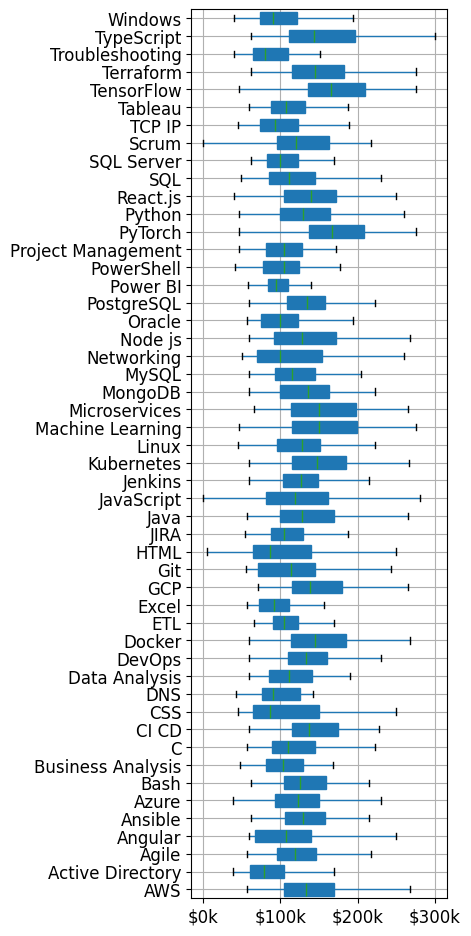

In [148]:
fig, ax = plt.subplots(figsize=(5, 10)) 
filtered_df.boxplot(column='ref_salary', by='skills_list', vert=False, patch_artist=True, showfliers=False, widths=0.7, ax=ax)

ax.set_title('')
ax.set_ylabel('')
fig.suptitle('')

# Reduce the y-ticks font size
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right', fontsize=12)
ax.tick_params(axis='x', labelsize=12)

# Format the x-ticks using a lambda function
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x/1000:.0f}k'))

# Adjust layout
fig.tight_layout(pad=2.0, w_pad=2.0, h_pad=2.0)

# Save the figure
fig.savefig('figures/boxplots_skills.jpeg', bbox_inches='tight')

plt.show()

In [149]:
postings_df_with_salary = postings_df[~postings_df.isna().any(axis = 1)]
postings_df_with_salary

,position,date,WorkType,levelMapping,Title,Company,Location,Link,job description,extracted_skills,...,Azure Virtual Desktops,ICD10,CISSP Certification,Microsoft Partner Program for CSP Resellers,Portchannel,Builder.io CMS,CheckPoint,System diagramming,Oracle RDBMS,Network Load Balancers
0,devops engineer,6/22/2024,remote,entry_level,Junior DevOps Engineer,Patterned Learning Career,"Boise, ID",https://www.linkedin.com/jobs/view/junior-devo...,\n\n\n This is a remote position.Juni...,"Jenkins, Octopus, Docker, Kubernetes, Git, Azu...",...,0,0,0,0,0,0,0,0,0,0
1,devops engineer,6/22/2024,remote,entry_level,DevOps Engineer 1,Granicus,United States,https://www.linkedin.com/jobs/view/devops-engi...,\n\n\nThe CompanyServing the People Who Serve ...,"Chef, GitLab, GitLabCI, Terraform, Kubernetes,...",...,0,0,0,0,0,0,0,0,0,0
3,devops engineer,6/22/2024,remote,entry_level,DevOps Engineer,Team Remotely Inc,"Boston, MA",https://www.linkedin.com/jobs/view/devops-engi...,\n\n\n This is a remote position. Dev...,"Jenkins, Octopus, Docker, Kubernetes, Git, Azu...",...,0,0,0,0,0,0,0,0,0,0
4,devops engineer,6/22/2024,remote,entry_level,DevOps Engineer,Cortica,"San Diego, CA",https://www.linkedin.com/jobs/view/devops-engi...,\n\n\n Cortica is looking for a DevOp...,"Git, GitHub, GitLab, AWS, CI/CD Tooling, Pipel...",...,0,0,0,0,0,0,0,0,0,0
7,devops engineer,6/22/2024,remote,entry_level,DevOps Engineer,Wealthfront,"Palo Alto, CA",https://www.linkedin.com/jobs/view/devops-engi...,\n\n\n This role supports US-based re...,"Linux, Chef, Puppet, Terraform, Ansible, Java,...",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6725,network administrator,6/22/2024,onsite,mid_senior,Network Engineer,"IT Engagements, Inc.","O'Fallon, IL",https://www.linkedin.com/jobs/view/network-eng...,\n\n\n Greetings from IT Engagements....,"Networking, LAN WAN, Firewalls, Security, Encr...",...,0,0,0,0,0,0,0,0,0,0
6732,network administrator,6/22/2024,onsite,mid_senior,IT - Network Administrator,"Specialized Recruiting Group - Raleigh-Durham, NC","North Carolina, United States",https://www.linkedin.com/jobs/view/it-network-...,\n\n\nSpecialized Recruiting Group is seeking ...,"Network Administration, Wide Area Network (WAN...",...,0,0,0,0,0,0,0,0,0,0
6733,network administrator,6/22/2024,onsite,mid_senior,Network Engineer,INSPYR Solutions,"Rockville, MD",https://www.linkedin.com/jobs/view/network-eng...,\n\n\nTitle: Network EngineerLocation: Fully r...,"AWS, BGP, CCNA, DHCP, DNS, EIGRP, ISIS, IP, IP...",...,0,0,0,0,0,0,0,0,0,0
6736,network administrator,6/22/2024,onsite,mid_senior,Information Technology Network Administrator,PTS Advance,"Sinclair, WY",https://www.linkedin.com/jobs/view/information...,\n\n\nIT Network Administrator III - Job Descr...,"Microsoft, Cisco, NET+, A, N+, MCSA, CCNA, JNC...",...,0,0,0,0,0,0,0,0,0,0


## Point-Biserial Correlation

In [150]:
# Create a binary matrix for skills
mlb = MultiLabelBinarizer(classes = top_50_skills)
skills_encoded = mlb.fit_transform(postings_df_with_salary['skills_list'])
skills_df = pd.DataFrame(skills_encoded, columns=mlb.classes_)

# Include the salary in the DataFrame
skills_df['ref_salary'] = postings_df_with_salary['ref_salary'].values

# Calculate the correlation matrix for skills and salary
skill_salary_corr = skills_df.corr()

# Extract the correlation of skills with salary
skill_salary_corr_with_salary = skill_salary_corr['ref_salary'].drop('ref_salary')


C:\Users\luanc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['* APIs', '* Agile', '* Airtable.com', '* BitBucket', '* C#', '* CG', '* CSS', '* Confluence', '* Distributed Systems', '* Git', '* IaC', '* JIRA', '* Java', '* LESS', '* MS Visio', '* Microservices', '* Play Framework', '* PowerShell', '* QuickBooks Online', '* RESTful API', '* React.js', '* Responsive Web Design', '* SASS', '* SOAP UI', '* SQL Server', '* SVN', '* SnapLogic', '* Snowflake', '* Teamwork', '* Unit Testing', '* Visual Basic', '* Web services', '* XML', '.NET CORE', '.NET Maui', '.NET framework', '.Net framework', '.Net/.Net Core', '2FA', '3D Printing', '3D computer vision', '3DX Enovia', '3rd Party Data Processor', '4GL', '802.11', '802.1d', '802.1q', '802.1q VLANs', '802.1x', '8570/8140 IAT II', '@RISK', 'A', 'A Certification', 'A strong understanding of security c

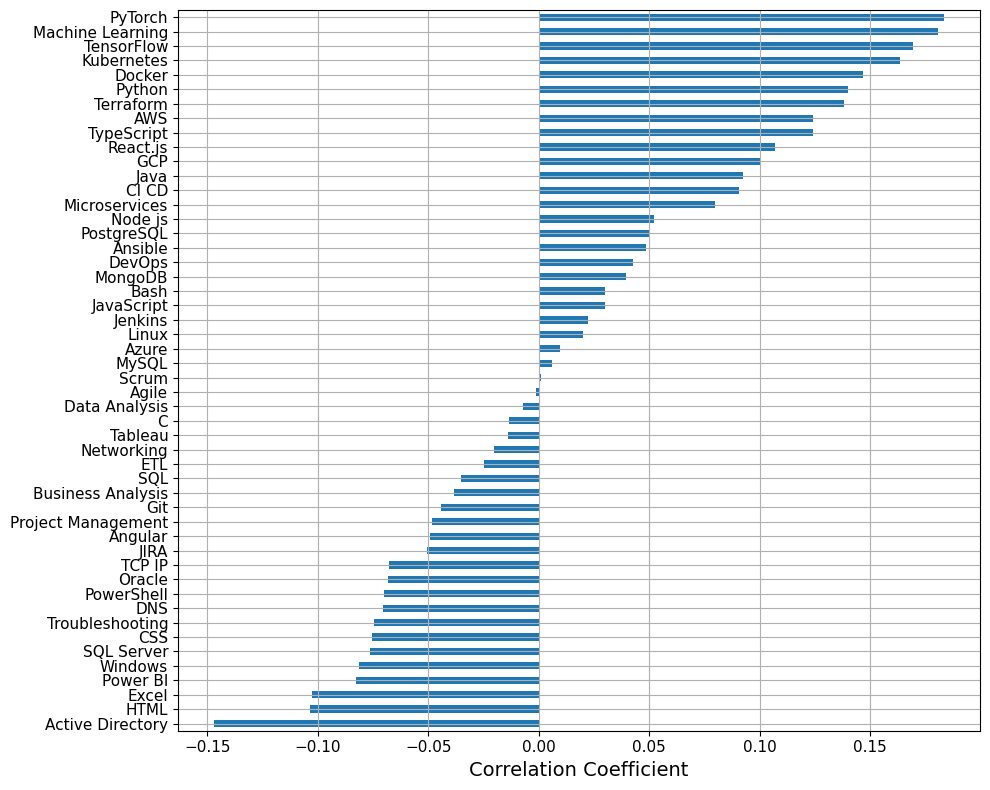

In [151]:
# Sort the correlations by value
sorted_corr = skill_salary_corr_with_salary.sort_values()

# Plot the correlations
plt.figure(figsize=(10, 8))
sorted_corr.plot(kind='barh')
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(True)
plt.tight_layout()
plt.savefig('figures/salary_corr.jpeg', bbox_inches='tight')
plt.show()


## Phi correlation

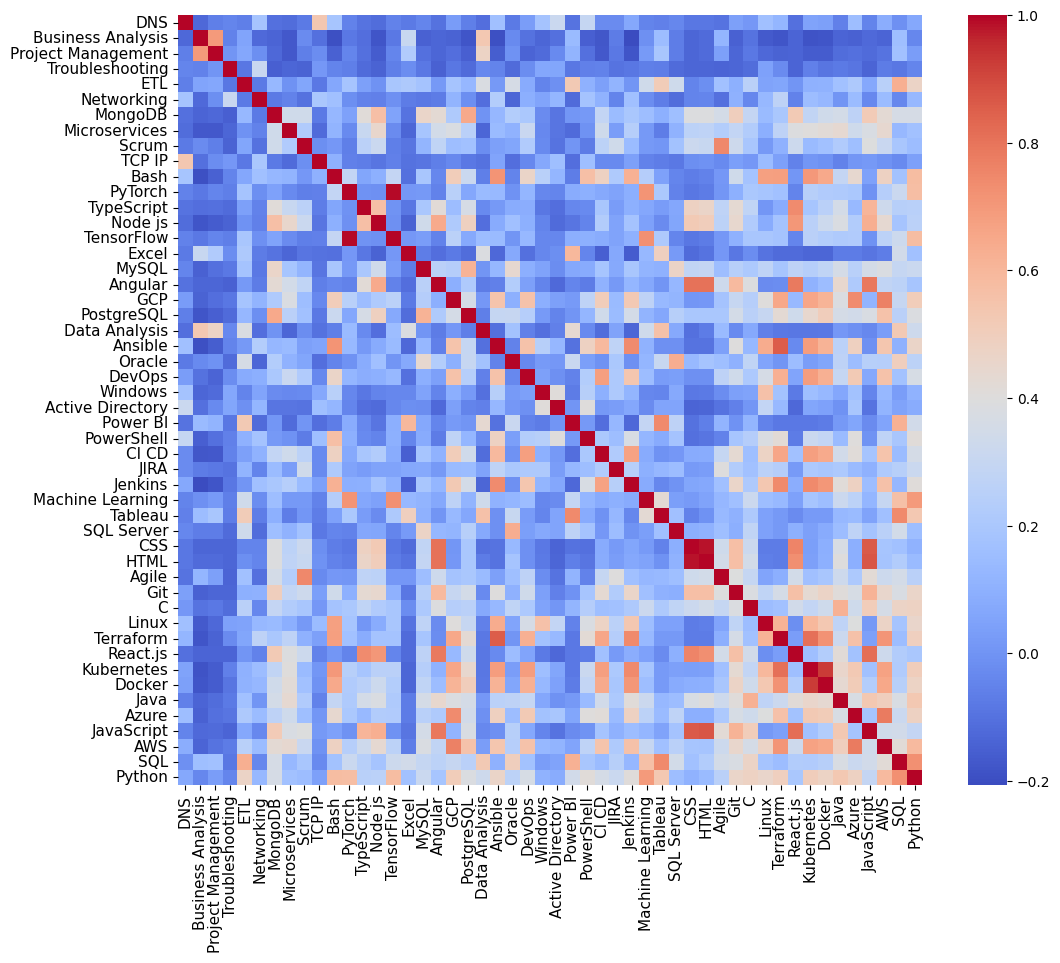

In [152]:
# Compute the co-occurrence matrix for skills
skills_co_occurrence_matrix = np.dot(skills_df.iloc[:, :-1].T, skills_df.iloc[:, :-1])

# Convert the co-occurrence matrix to a DataFrame for better readability
skills_co_occurrence_df = pd.DataFrame(skills_co_occurrence_matrix, index=mlb.classes_, columns=mlb.classes_)

# Calculate the correlation matrix for the co-occurrence matrix
skills_co_occurrence_corr = skills_co_occurrence_df.corr()

# Plotting the skill co-occurrence correlation matrix using seaborn
plt.figure(figsize=(12, 10))

sns.heatmap(skills_co_occurrence_corr, cmap='coolwarm', annot=False, fmt=".2f")
plt.xticks(rotation=90, fontsize=11)
plt.yticks(fontsize=11)
plt.savefig('figures/skill_corr.jpeg', bbox_inches='tight')
plt.show()

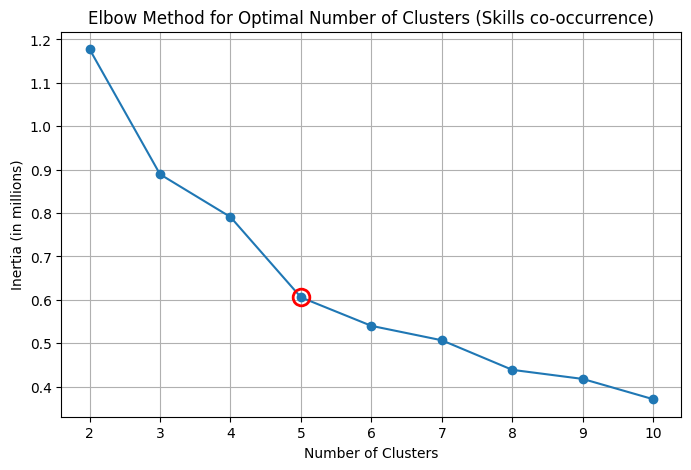

In [223]:
# Create the co-occurrence matrix
co_occurrence_matrix = skills_df.iloc[:, :-1].T.dot(skills_df.iloc[:, :-1])

# Run K-Means for different numbers of clusters and calculate WCSS
wcss = []
range_n_clusters = range(2, 11)  # Test between 2 and 10 clusters

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(co_occurrence_matrix)
    
    # Append the within-cluster sum of squares
    wcss.append(kmeans.inertia_)

# Convert WCSS values to millions
wcss_millions = [x / 1e6 for x in wcss]

# Plot the WCSS to visualize the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, wcss_millions, marker='o', label='WCSS')

# Highlight the chosen cluster (e.g., 5 clusters) with a red circle
chosen_cluster = 5
plt.plot(chosen_cluster, wcss_millions[chosen_cluster - 2], 'ro', markersize=12, markerfacecolor='none', markeredgewidth=2)

# Adjust y-axis to display values in millions
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.1f}'))

# Final plot adjustments
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (in millions)')
plt.title('Elbow Method for Optimal Number of Clusters (Skills co-occurrence)')
plt.grid(True)
plt.savefig('./figures/cluster_skills')
plt.show()


In [184]:
# Apply K-Means with 4 clusters
kmeans = KMeans(n_clusters=5, random_state=42)
co_occurrence_labels = kmeans.fit_predict(co_occurrence_matrix)

# Map the clustering results back to the skills
skill_columns = skills_df.columns[:-1]  # Exclude only the 'ref_salary' column if it exists
skill_clusters = pd.DataFrame({
    'skill': skill_columns,
    'co_occurrence_cluster': co_occurrence_labels
})

# Print the skills in each cluster
for cluster in range(5):
    print(f"Cluster {cluster}:")
    print(skill_clusters[skill_clusters['co_occurrence_cluster'] == cluster]['skill'].values)
    print()

Cluster 0:
['Git' 'Linux' 'Terraform' 'Kubernetes' 'Docker' 'Java' 'Azure' 'AWS']

Cluster 1:
['Python']

Cluster 2:
['DNS' 'Business Analysis' 'Project Management' 'Troubleshooting' 'ETL'
 'Networking' 'MongoDB' 'Microservices' 'Scrum' 'TCP IP' 'Bash' 'PyTorch'
 'TypeScript' 'Node js' 'TensorFlow' 'Excel' 'MySQL' 'Angular' 'GCP'
 'PostgreSQL' 'Data Analysis' 'Ansible' 'Oracle' 'DevOps' 'Windows'
 'Active Directory' 'Power BI' 'PowerShell' 'CI CD' 'JIRA' 'Jenkins'
 'Machine Learning' 'Tableau' 'SQL Server' 'Agile' 'C']

Cluster 3:
['SQL']

Cluster 4:
['CSS' 'HTML' 'React.js' 'JavaScript']



In [200]:
average_salaries = filtered_df.groupby('skills_list')['ref_salary'].median().reindex(top_50_skills)
average_salaries

skills_list
DNS                    91050.0000
Business Analysis     104000.0000
Project Management    104500.0000
Troubleshooting        79615.0000
ETL                   105000.0000
Networking            100000.0000
MongoDB               136000.0000
Microservices         150000.0000
Scrum                 119800.0000
TCP IP                 93655.7275
Bash                  125975.0000
PyTorch               167400.0000
TypeScript            144228.0000
Node js               128000.0000
TensorFlow            165000.0000
Excel                  91300.0000
MySQL                 115000.0000
Angular               107390.0000
GCP                   139000.0000
PostgreSQL            134250.0000
Data Analysis         111000.0000
Ansible               130000.0000
Oracle                100000.0000
DevOps                133570.0000
Windows                91095.0000
Active Directory       79550.0000
Power BI               95000.0000
PowerShell            105250.0000
CI CD                 137500.0000
JI

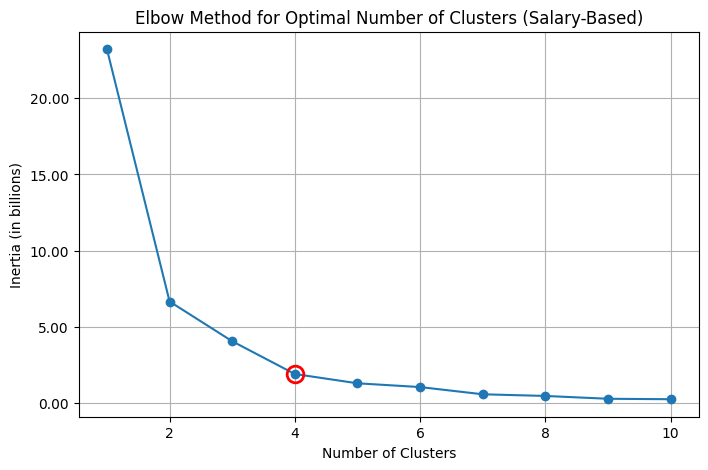

In [201]:
# Run K-Means clustering with different numbers of clusters and calculate the inertia
wcss = []  # Within-cluster sum of squares
range_n_clusters = range(1, 11)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(average_salaries.values.reshape(-1, 1))
    wcss.append(kmeans.inertia_)

# Convert WCSS values to billions
wcss_billions = [x / 1e9 for x in wcss]

# Plot the Elbow Method to determine the optimal number of clusters
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, wcss_billions, marker='o', label='WCSS')

# Highlight the chosen cluster (4 clusters) with a red circle
chosen_cluster = 4
plt.plot(chosen_cluster, wcss_billions[chosen_cluster - 1], 'ro', markersize=12, markerfacecolor='none', markeredgewidth=2)

# Adjust y-axis to display values in billions
ax = plt.gca()
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.2f}'))

# Final plot adjustments
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (in billions)')
plt.title('Elbow Method for Optimal Number of Clusters (Salary-Based)')
plt.grid(True)
plt.savefig('./figures/cluster_salary')
plt.show()


In [221]:
# Run K-Means clustering on the average salary values
chosen_n_clusters = 4
kmeans = KMeans(n_clusters=chosen_n_clusters, random_state=42)
salary_labels = kmeans.fit_predict(average_salaries.values.reshape(-1, 1))

# Map the clustering results back to the skills
salary_clusters = pd.DataFrame({
    'skill': top_50_skills,
    'salary_cluster': salary_labels + 1
})

# Display the skills in each cluster
for cluster in range(1, chosen_n_clusters + 1):
    print(f"Cluster {cluster}:")
    print(salary_clusters[salary_clusters['salary_cluster'] == cluster]['skill'].values)
    print()

Cluster 1:
['Microservices' 'PyTorch' 'TypeScript' 'TensorFlow' 'GCP'
 'Machine Learning' 'Terraform' 'React.js' 'Kubernetes' 'Docker']

Cluster 2:
['Business Analysis' 'Project Management' 'ETL' 'Networking' 'MySQL'
 'Angular' 'Data Analysis' 'Oracle' 'PowerShell' 'JIRA' 'Tableau'
 'SQL Server' 'Git' 'C' 'SQL']

Cluster 3:
['DNS' 'Troubleshooting' 'TCP IP' 'Excel' 'Windows' 'Active Directory'
 'Power BI' 'CSS' 'HTML']

Cluster 4:
['MongoDB' 'Scrum' 'Bash' 'Node js' 'PostgreSQL' 'Ansible' 'DevOps'
 'CI CD' 'Jenkins' 'Agile' 'Linux' 'Java' 'Azure' 'JavaScript' 'AWS'
 'Python']



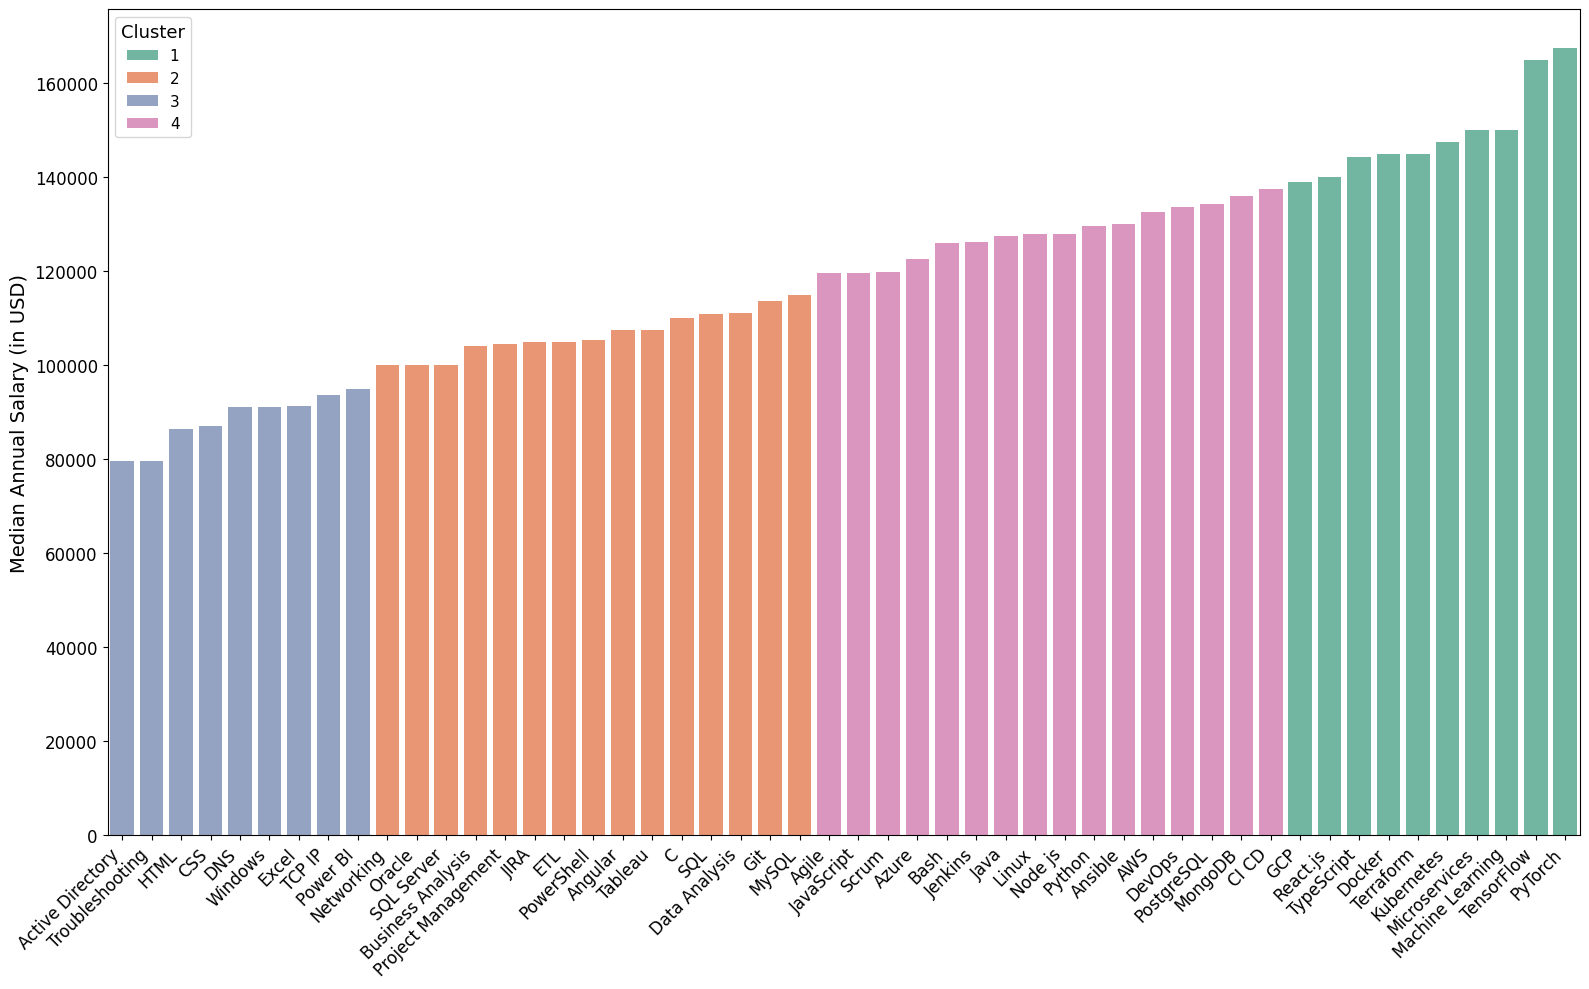

In [222]:
# Merge the sorted average salaries back to the salary_clusters DataFrame
salary_clusters['average_salary'] = average_salaries.values

salary_clusters_sorted = salary_clusters.sort_values(by='average_salary')

# Create the plot
plt.figure(figsize=(16, 10))  # Increase figure size for better readability
sns.barplot(x='skill', y='average_salary', hue='salary_cluster', data=salary_clusters_sorted, palette='Set2')

# Customize the plot
plt.xlabel('')  
plt.ylabel('Median Annual Salary (in USD)', fontsize=14)  
plt.xticks(rotation=45, ha='right', fontsize=12)  
plt.yticks(fontsize=12)  # Increase y-ticks font size
plt.legend(title='Cluster', title_fontsize='13', fontsize='11')  
#plt.title('Skills vs. Median Salary Colored by Cluster', fontsize=16)
plt.tight_layout()

plt.savefig('./figures/salary_cluster_plot')
# Show the plot
plt.show()

